# Generate Dataset

## Music Files

In [48]:
import csv
import os
import random
import warnings
from music21 import stream, note, duration, pitch
from music21.musicxml import m21ToXml

# Suppress annoying MusicXMLWarning
warnings.filterwarnings("ignore", category=m21ToXml.MusicXMLWarning)

def generate_random_note():
    '''
    A function to generate a random note based on a predefined list
    of pitches and durations.
    '''
    pitches = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5']
    durations = ['whole', 'half', 'quarter', 'eighth', '16th']

    selected_pitch = random.choice(pitches)
    selected_duration = random.choice(durations)

    n = note.Note()
    n.pitch = pitch.Pitch(selected_pitch)
    n.duration = duration.Duration(selected_duration)

    return n, selected_pitch, selected_duration

def pitch_to_label(pitch):
    pitch_dict = {'C4': -7, 'D4': -6, 'E4': -5, 'F4': -4, 'G4': -3, 'A4': -2, 'B4': -1,
                  'C5': 0, 'D5': 1, 'E5': 2, 'F5': 3, 'G5': 4}
    return pitch_dict[pitch]

def generate_synthetic_single_musicxml(num_samples=10, output_folder='../raw_data/musicxml_files', label_file='../raw_data/labels.csv'):
    '''
    A function to create musicXML files with a single note of music, along with a label file.
    '''
    # get CWD and create folders if needed
    current_dir = os.getcwd()
    output_folder = os.path.abspath(os.path.join(current_dir, output_folder))
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    label_file = os.path.abspath(os.path.join(current_dir, label_file))

    # create music files and labels
    with open(label_file, 'w', newline='') as csvfile:
        label_writer = csv.writer(csvfile)
        label_writer.writerow(['filename', 'label'])
        for i in range(num_samples):
            s = stream.Stream()
            n, selected_pitch, selected_duration = generate_random_note()
            s.append(n)
            filename = f'note_{selected_pitch}_{selected_duration}_{i}.musicxml'
            s.write('musicxml', fp=os.path.join(output_folder, filename))
            label = pitch_to_label(selected_pitch)
            label_writer.writerow([filename.replace('.musicxml', '.png'), label])

    return None


In [49]:
generate_synthetic_single_musicxml(num_samples=100)

## PNG Images

In [50]:
import subprocess
import platform
import os


# get the right path for musescore based on system
def get_musescore_path():
    system = platform.system()
    if system == 'Windows':
        return r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'  # Update this path if necessary
    elif system == 'Darwin':  # macOS
        return '/Applications/MuseScore 4.app/Contents/MacOS/mscore'
    elif system == 'Linux':
        return '/usr/bin/musescore4'  # Update this path if necessary
    else:
        raise ValueError("Unsupported operating system")


def convert_musicxml_to_png(input_folder='../raw_data/musicxml_files', output_folder='../raw_data/sheet_images'):
    current_dir = os.getcwd()
    input_folder = os.path.abspath(os.path.join(current_dir, input_folder))
    output_folder = os.path.abspath(os.path.join(current_dir, output_folder))
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    musescore_path = get_musescore_path()

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.musicxml'):
            input_path = os.path.join(input_folder, file_name)
            output_filename = file_name.replace('.musicxml', '.png')
            output_path = os.path.join(output_folder, output_filename)
            result = subprocess.run([musescore_path, input_path, '-o', output_path], stderr=subprocess.PIPE)
            if result.returncode != 0:
                print(f"Error processing {file_name}: {result.stderr.decode('utf-8')}")

            # Check if the file has a '-1' suffix and rename it
            generated_filename = output_filename.replace('.png', '-1.png')
            generated_path = os.path.join(output_folder, generated_filename)
            if os.path.exists(generated_path):
                os.rename(generated_path, output_path)

    return None

In [51]:
convert_musicxml_to_png()

# Convert Image and Embed Labels

## For rows of music, to be tried later

In [3]:
import cv2
import numpy as np

#### This will need to be adjusted (img --> file) #####

def create_dataset(num_samples):
    images = []
    labels = []
    for i in range(num_samples):
        img = cv2.imread(f'random_sample_{i}.png', cv2.IMREAD_GRAYSCALE)
        img_array = np.array(img)

        # Example bounding box creation (this should be based on actual note positions)
        bounding_boxes = [(50, 50, 100, 100)]  # Placeholder
        label = ['C4']  # Placeholder

        images.append(img_array)
        labels.append((bounding_boxes, label))

    return np.array(images), labels

## For single note files

### Travis Code for Cropping

In [52]:
import os
from PIL import Image

def crop_note_from_png_folder(input_folder, output_folder):
    """
    Crops all PNG images in the specified folder to the specified dimensions.

    Parameters:
    - input_folder (str): The path to the input folder containing PNG images.
    - output_folder (str): The path to the folder to save the cropped images.
    """
    # Define the crop box (left, upper, right, lower)
    crop_box = (506, 536, 580, 870)  # Replace these values with your desired dimensions

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.png'):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the image file
            with Image.open(input_path) as img:
                # Crop the image using the provided crop box
                cropped_img = img.crop(crop_box)

                # Save the cropped image
                cropped_img.save(output_path)

            # print(f'Cropped image saved to {output_path}')


In [53]:
input_folder = '../raw_data/sheet_images'
output_folder = '../raw_data/cropped_images'
crop_note_from_png_folder(input_folder, output_folder)

In [54]:
###### for if we dont have a labeled filed ########

# import cv2
# import numpy as np

# def process_single_note_image(image_path, label):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img_array = np.array(img)

#     # As we know it's a single note, let's assume the bounding box covers most of the image
#     h, w = img_array.shape
#     bounding_box = [0, 0, w, h]

#     return img_array, bounding_box, label

# def create_single_note_dataset(image_folder='../raw_data/sheet_images', label_data='../raw_data/musicxml_files'):
#     images = []
#     bounding_boxes = []
#     labels = []

#     for file_name in os.listdir(image_folder):
#         if file_name.endswith('.png'):
#             note_info = file_name.replace('.png', '').split('_')[1:]  # Extract pitch and duration from filename
#             label = '_'.join(note_info)

#             img_array, bounding_box, label = process_single_note_image(os.path.join(image_folder, file_name), label)
#             images.append(img_array)
#             bounding_boxes.append(bounding_box)
#             labels.append(label)

#     return np.array(images), bounding_boxes, labels



##### using csv file for labels #########

import pandas as pd
import cv2
import numpy as np

def load_labels(label_file='../raw_data/labels.csv'):
    labels_df = pd.read_csv(label_file)
    return labels_df.set_index('filename').to_dict()['label']

def create_single_note_dataset(image_folder='../raw_data/cropped_images', label_file='../raw_data/labels.csv'):
    labels = load_labels(label_file)
    images = []
    bounding_boxes = []
    image_labels = []

    for file_name in os.listdir(image_folder):
        if file_name.endswith('.png'):
            img_path = os.path.join(image_folder, file_name)
            label = labels[file_name]
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Create a bounding box covering the entire image
            h, w = img_array.shape
            bounding_box = [0, 0, w, h]

            images.append(img_array)
            bounding_boxes.append(bounding_box)
            image_labels.append(label)

    return np.array(images), bounding_boxes, image_labels

In [55]:
images, bounding_boxes, image_labels = create_single_note_dataset()

In [56]:
images.shape

(100, 334, 74)

# Preprocess

In [57]:
import cv2
import numpy as np

# Example target size for the model (for CNNs, it could be something like 64x64 or 128x128)
target_size = (128, 128)  # Width x Height

# Assuming `images` is a list of images loaded as numpy arrays
resized_images = []

for img in images:
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    resized_images.append(resized_img)

# Convert back to numpy array
resized_images = np.array(resized_images)

# Check the shape of the resized images
print(f"Shape of resized images: {resized_images.shape}")

Shape of resized images: (100, 128, 128)


In [58]:
def resize_with_aspect_ratio(img, target_size):
    h, w = img.shape

    # Calculate the aspect ratio
    aspect_ratio = w / h

    # Determine the target width and height based on the target size
    if aspect_ratio > 1:  # Wider image
        new_w = target_size[0]
        new_h = int(target_size[0] / aspect_ratio)
    else:  # Taller image
        new_h = target_size[1]
        new_w = int(target_size[1] * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Add padding to make the image square
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [255]  # Assuming a white background (255 for grayscale)
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_img


In [59]:
resized_images = [resize_with_aspect_ratio(img, target_size) for img in images]
resized_images = np.array(resized_images)

print(f"Shape of resized and padded images: {resized_images.shape}")

Shape of resized and padded images: (100, 128, 128)


# Model

## Structure

### Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def train_logistic_regression(X, y):
    X_flat = X.reshape(X.shape[0], -1)
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return accuracy

### CNN

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_cnn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = create_cnn_model(X_train.shape[1:], num_classes=10)  # Example with 10 classes
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    return model.evaluate(X_test, y_test)


In [ ]:
# for running the model, don't run this cell until others are good

images, labels = create_dataset(100)  # Generate 100 samples
preprocessed_images = np.array([preprocess_image(img) for img in images])

# Logistic Regression
logistic_accuracy = train_logistic_regression(preprocessed_images, labels)

# CNN
cnn_accuracy = train_cnn(preprocessed_images, labels)

## Running Logistic Regression Model

In [61]:
from sklearn.model_selection import train_test_split

# Assume 'images' is your X and 'image_labels' is your y from step 4
X_train, X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42)


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the images for logistic regression
n_samples, h, w = X_train.shape
X_train_flat = X_train.reshape(n_samples, h * w)
X_test_flat = X_test.reshape(X_test.shape[0], h * w)

# Train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_flat, y_train)

# Make predictions and evaluate
y_pred = logistic_model.predict(X_test_flat)
logistic_accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {logistic_accuracy}")


Logistic Regression Accuracy: 1.0


# Testing/Troubleshooting...Not Needed in Python file

In [ ]:
# Check shape of the images array
print(f"Shape of images array before reshaping: {images.shape}")

# Ensure images are correctly shaped for CNN
if len(images.shape) == 3:  # Correct shape should be (num_images, height, width)
    X_cnn = np.array(images).reshape(-1, images.shape[1], images.shape[2], 1)
else:
    raise ValueError("Images array is not in the expected shape. Check the preprocessing steps.")

# Proceed with splitting and training as described earlier
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)


In [1]:
def create_single_note_dataset(image_folder='../raw_data/sheet_images', label_file='../raw_data/labels.csv'):
    labels = load_labels(label_file)
    images = []
    bounding_boxes = []
    image_labels = []

    for file_name in os.listdir(image_folder):
        if file_name.endswith('.png'):
            img_path = os.path.join(image_folder, file_name)
            label = labels[file_name]

            # Load image and check shape
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            print(f"Loaded {file_name} with shape {img_array.shape}")

            # Verify that the image is loaded correctly as a 2D array
            if len(img_array.shape) != 2:
                raise ValueError(f"Image {file_name} is not in the expected shape (height, width).")

            # Create a bounding box covering the entire image
            h, w = img_array.shape
            bounding_box = [0, 0, w, h]

            images.append(img_array)
            bounding_boxes.append(bounding_box)
            image_labels.append(label)

    return np.array(images), bounding_boxes, image_labels


# Testing Output/Prediction

In [67]:
X_test.shape

(20, 334, 74)

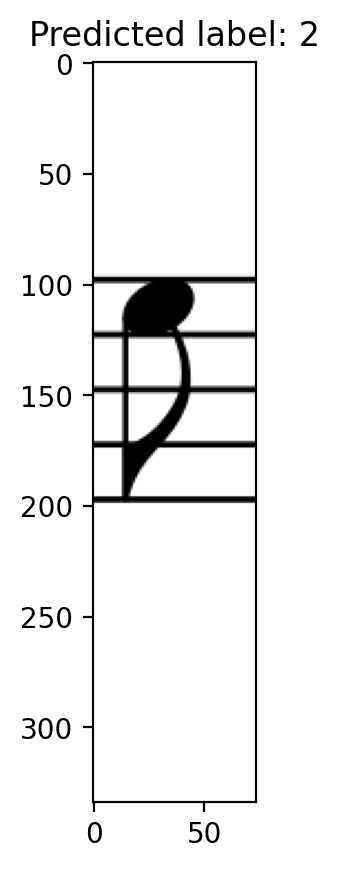

In [73]:
import matplotlib.pyplot as plt

# input the number you want to check
test_note = X_test[18]

predicted_label = logistic_model.predict(test_note.reshape(1, -1))[0]
predicted_label

# Using our cropped pixels
height, width = 334, 74

# Reshape flattened image
image = test_note.reshape(height, width)

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Predicted label: {predicted_label}")
plt.show()
